In [1]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
#!pip install --upgrade oracledb

In [79]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [80]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [81]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [5]:
# Saisir ci-dessous la plateforme qui vous a été attribuée. Cela correspond au nomPlateforme dans la table PLATEFORME de la base de données
# Par exemple NOM_PLATEFORME = "Switch"
NOM_PLATEFORME = "Sega Saturn"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = '"ILUIS"'

```python
# Gestion des droits de GESTIONJV déjà effectué lorsque connecté par iluis
tables = [
    '"CATEGORIEJEU"', '"CATEGORIEPLATEFORME"', '"CLASSIFICATIONAGE"', '"COMPAGNIE"',
    '"DATESORTIE"', '"FRANCHISE"', '"JEU"', '"GENRE"', '"MODALITE"', '"MODEMULTIJOUEUR"',
    '"MOTCLE"', '"MOTEUR"', '"PLATEFORME"', '"POPULARITE"', '"REGION"', '"THEME"', '"TITREALTERNATIF"',
    '"LOCALISATIONJEU"', '"MOTCLEJEU"', '"GENREJEU"', '"SIMILARITE"', '"CLASSIFICATIONJEU"', '"COMPAGNIEJEU"', 
    '"MOTEURJEU"', '"PLATEFORMEMOTEUR"', '"THEMEJEU"', '"FRANCHISEJEU"', '"MODALITEJEU"'
]

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    utilisateur = '"GESTIONJV"'
    
    for table in tables:
        sql_grant = f"""
        GRANT SELECT, INSERT, UPDATE, DELETE ON {SCHEMA}.{table} TO {utilisateur}
        """
        curseur.execute(sql_grant)
        
    sql_grant = f"""
    GRANT EXECUTE ON {SCHEMA}.DETAILS_SORTIES TO {utilisateur}
    """
    curseur.execute(sql_grant)
    connexion.commit()
    curseur.close()

print("✅ Droits accordés à l'utilisateur GestionJV")

# TABLEAU DE BORD PLATEFORME

## Partie consultation des données

In [111]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

Login :  iluis
Mot de passe :  ········


In [99]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.PLATEFORME WHERE nomPlateforme LIKE (:libelle)",{"libelle":NOM_PLATEFORME})
id_plateforme = int(data.IDPLATEFORME.iloc[0])
print(f"Identifiant de la plateforme : {id_plateforme}")

Identifiant de la plateforme : 32


### Statistiques de base

#### Nombre de jeux publiés sur cette plateforme

In [62]:
def nbrDeJeux():
    data = requete_vers_dataframe(
    conn,
    f"""
    SELECT COUNT(DISTINCT JEU.idJeu)
    FROM {SCHEMA}.PLATEFORME
    INNER JOIN {SCHEMA}.DATESORTIE ON PLATEFORME.idPlateforme = DATESORTIE.idPlateforme
    INNER JOIN {SCHEMA}.JEU ON JEU.idJeu = DATESORTIE.idJeu
    WHERE nomPlateforme LIKE :libelle
    """,
    {"libelle": NOM_PLATEFORME}
    )
    nbrJeux = int(data.iloc[0, 0])
    print("Nombres de jeux : ", nbrJeux)

In [63]:
# Calculer avec une requête et afficher le nombre de jeux publiés sur cette plateforme
nbrDeJeux()

Nombres de jeux :  787


#### Nombre de compagnies ayant développé sur cette plateforme

In [83]:
# Calculer avec une requête et afficher le nombre de compagnies ayant développé sur cette plateforme
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT COUNT(DISTINCT CJ.idCompagnie)
    FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPLATEFORME = DS.IdPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = DS.idJeu
    WHERE P.nomPlateforme LIKE :libelle
    """,
    {"libelle": NOM_PLATEFORME}
)

nbrCompagnies = int(data.iloc[0, 0])
print("Nombre de compagnies : ", nbrCompagnies)

Nombre de compagnies :  453


In [84]:
# Calculer avec une requête et afficher le nom des compagnies ayant développé sur cette plateforme
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT DISTINCT nomCompagnie
    FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPLATEFORME = DS.IdPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIE CO ON CO.idCompagnie = CJ.idCompagnie
    WHERE P.nomPlateforme LIKE :libelle
    """,
    {"libelle": NOM_PLATEFORME}
)

for compagnie in data["NOMCOMPAGNIE"]:
    print("-", compagnie)

- Taito
- Extreme Co.,Ltd
- Banpresto
- System Vision
- Yumedia
- Xing Entertainment
- Sega Enterprises, Inc.
- ProSoft
- Headroom
- Electronic Arts Victor
- Eidos Interactive
- Winkysoft
- Micronet
- Aisystem Tokyo
- Psikyo
- Hudson Soft
- Red Entertainment
- Quest
- JAMP
- Magical Formation
- Hearty Robin
- Stone Heads
- Fill-in-Cafe
- Entertainment Software Publishing Inc.
- Imagineering Inc.
- Russ, Ltd.
- Amuse
- Enix America Corporation
- XL2
- Smart Dog
- Infini Entertainment Technology
- Tamtam
- Image Works
- G-mode
- iNiS
- Sky Think Systems
- NCS Masaya
- JVC
- Kronos Digital Entertainment
- Philips Interactive Media
- Masaya Games
- Scarab Entertainment
- Sakata SAS
- Societa
- Sonic Team
- NCS
- Reindeer
- Dreamworks Interactive
- SNK
- Acclaim
- Compile
- BMG Interactive Entertainment
- Masaya
- Tose Software
- Nextech
- Takara
- Asmik Ace
- Treasure
- HAMSTER
- Tose
- Data West
- Tantalus Interactive
- Daft
- Backbone Entertainment
- Coconuts Japan
- Victor Interactive S

### Jeux

#### Répartition des jeux par année

In [64]:
# Calculer avec une requête et afficher le nombre de jeux publiés par année sur cette plateforme
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT EXTRACT(YEAR FROM DS.dateSortie) AS annee, COUNT(J.idJeu) AS nbrJeu
    FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPlateforme = DS.idPlateforme
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = DS.idJeu
    WHERE P.nomPlateforme LIKE :libelle
    GROUP BY EXTRACT(YEAR FROM DS.dateSortie)
    ORDER BY EXTRACT(YEAR FROM DS.dateSortie)
    """,
    {"libelle": NOM_PLATEFORME}
)

for _, row in data.iterrows():
    if (pd.isna(row['ANNEE'])):
        print('- Jeux sans date de sortie : ', int(row['NBRJEU']))
    else :
        print('- ', int(row['ANNEE']), ' : ', int(row['NBRJEU']))

-  1988  :  1
-  1993  :  1
-  1994  :  11
-  1995  :  140
-  1996  :  291
-  1997  :  290
-  1998  :  154
-  1999  :  10
-  2000  :  2
-  2003  :  1
-  2020  :  1
-  2021  :  2
-  2022  :  2
-  2023  :  1
-  2024  :  3
- Jeux sans date de sortie :  43


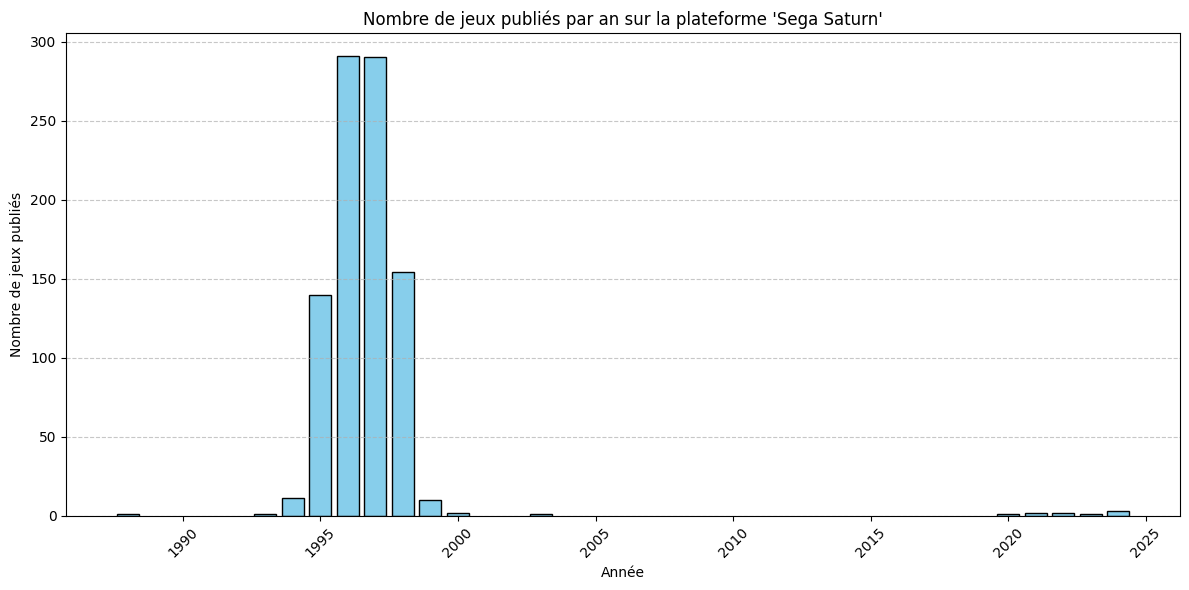

In [13]:
# Faire un histogramme des sorties par année

data.columns = ['annee', 'nbrJeu']

# Supprimer les lignes avec des années manquantes
data = data.dropna(subset=['annee'])

# Convertir les années en entiers
data['annee'] = data['annee'].astype(int)
data['nbrJeu'] = data['nbrJeu'].astype(int)

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
plt.bar(data['annee'], data['nbrJeu'], color='skyblue', edgecolor='black')

plt.xlabel("Année")
plt.ylabel("Nombre de jeux publiés")
plt.title(f"Nombre de jeux publiés par an sur la plateforme '{NOM_PLATEFORME}'")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.tight_layout()
plt.show()


#### Top 10 des jeux les mieux notés par les utilisateurs sur cette plateforme

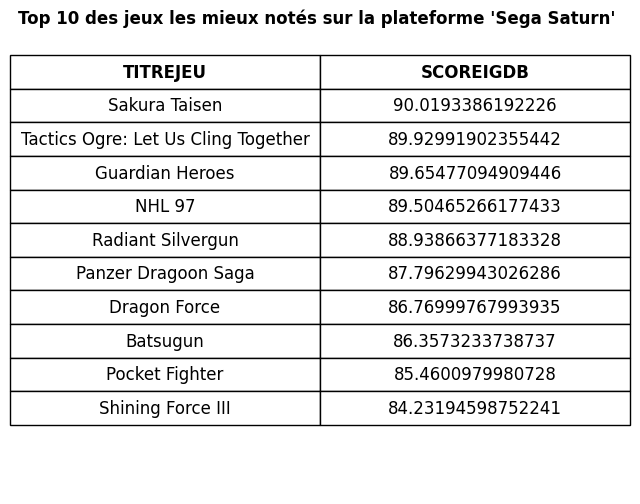

In [14]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT DISTINCT J.titreJeu, J.scoreIGDB
    FROM iluis.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPlateforme = DS.idPlateforme
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = DS.idJeu
    WHERE P.nomPlateforme LIKE :libelle AND J.scoreIGDB IS NOT NULL
    ORDER BY J.scoreIGDB DESC
    """,
    {"libelle": NOM_PLATEFORME}
)
'''for i in range(10):
    print("-", str(data.iloc[i, 0]), " : ", data.iloc[i, 1])
'''
fig, ax = plt.subplots(figsize=(8, 6))  # Taille du graphique
data_top_10 = data.head(10)
ax.axis('off')

table1 = ax.table(cellText=data_top_10.values, colLabels=data_top_10.columns, loc='center', cellLoc='center', colLoc='center', bbox=[0, 0.15, 1, 0.8])

table1.auto_set_font_size(False)
table1.set_fontsize(12)

# première ligne en gras
for (row, col), cell in table1.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

plt.title(f"Top 10 des jeux les mieux notés sur la plateforme '{NOM_PLATEFORME}' ", fontweight='bold')
plt.show()

#### Répartition des jeux par catégorie

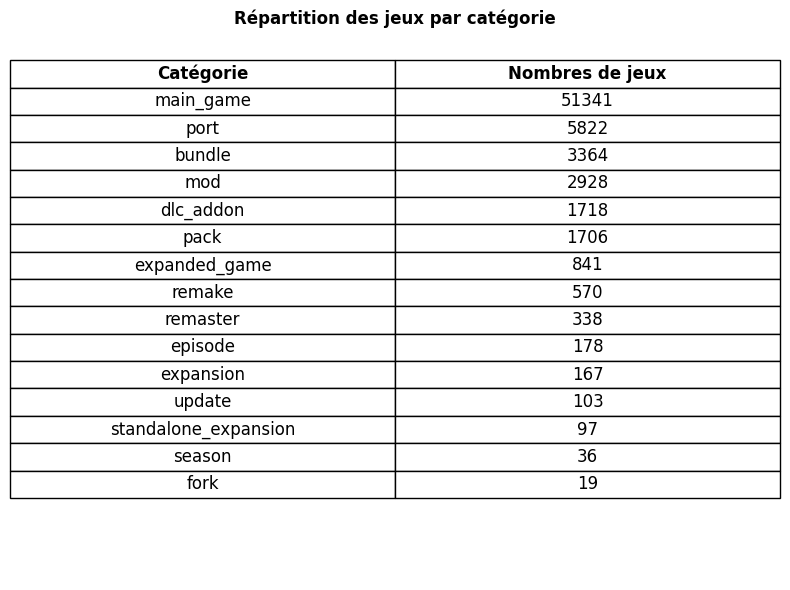

In [15]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau

data = requete_vers_dataframe(
    conn,
    f"""
    SELECT CJ.nomCategorieJeu as "Catégorie", COUNT(J.idJeu) as "Nombres de jeux"
    FROM {SCHEMA}.CATEGORIEJEU CJ
    INNER JOIN {SCHEMA}.JEU J ON J.categorieJeu = CJ.idCategorieJeu
    GROUP BY CJ.nomCategorieJeu
    ORDER BY COUNT(J.idJeu) DESC, CJ.nomCategorieJeu ASC
    """
)
fig, ax = plt.subplots(figsize=(8, 6))  # Taille du graphique
ax.axis('off')
table = ax.table(cellText=data.values, colLabels=data.columns, loc='center', cellLoc='center', colLoc='center', bbox=[0, 0.15, 1, 0.8])

table.auto_set_font_size(False)
table.set_fontsize(12)

# première ligne en gras
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

plt.title("Répartition des jeux par catégorie", fontweight='bold')
plt.tight_layout()
plt.show()

### Compagnies

#### Tableau de répartition des compagnies ayant développé sur cette plateforme par pays

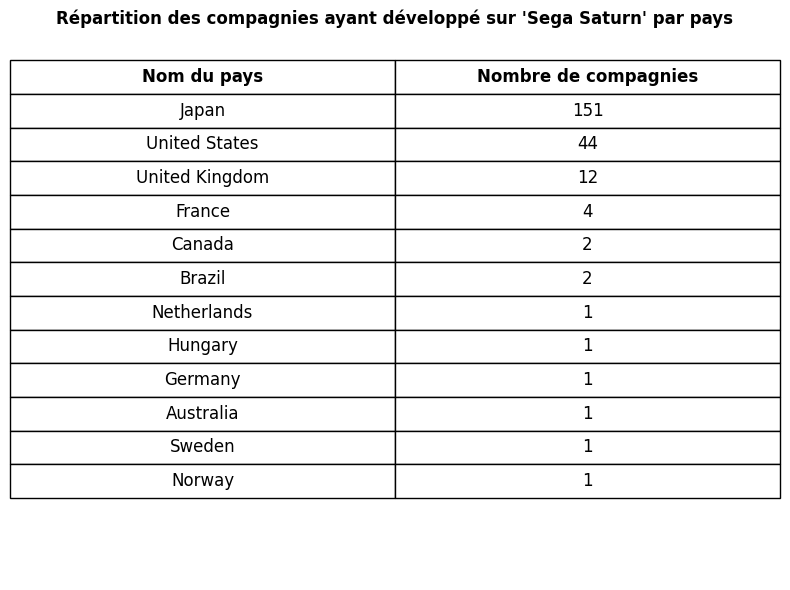

In [16]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT DISTINCT PI.nomPays AS "Nom du pays", COUNT(DISTINCT CO.idCompagnie) AS "Nombre de compagnies"
    FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPLATEFORME = DS.IdPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIE CO ON CO.idCompagnie = CJ.idCompagnie
    INNER JOIN PAYSISO PI ON PI.code_numerique = CO.PaysCompagnie
    WHERE P.nomPlateforme LIKE :libelle
    GROUP BY PI.nomPays
    ORDER BY COUNT(DISTINCT CO.idCompagnie) DESC
    """,
    {"libelle": NOM_PLATEFORME}
)

fig, ax = plt.subplots(figsize=(8, 6))  # Taille du graphique
ax.axis('off')
table = ax.table(cellText=data.values, colLabels=data.columns, loc='center', cellLoc='center', colLoc='center', bbox=[0, 0.15, 1, 0.8])

table.auto_set_font_size(False)
table.set_fontsize(12)

# première ligne en gras
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

plt.title(f"Répartition des compagnies ayant développé sur '{NOM_PLATEFORME}' par pays", fontweight='bold')
plt.tight_layout()
plt.show()

#### Graphique : top 25 des compagnies ayant développé sur cette plateforme  les mieux notées en moyenne par les utilisateurs d'IGDB

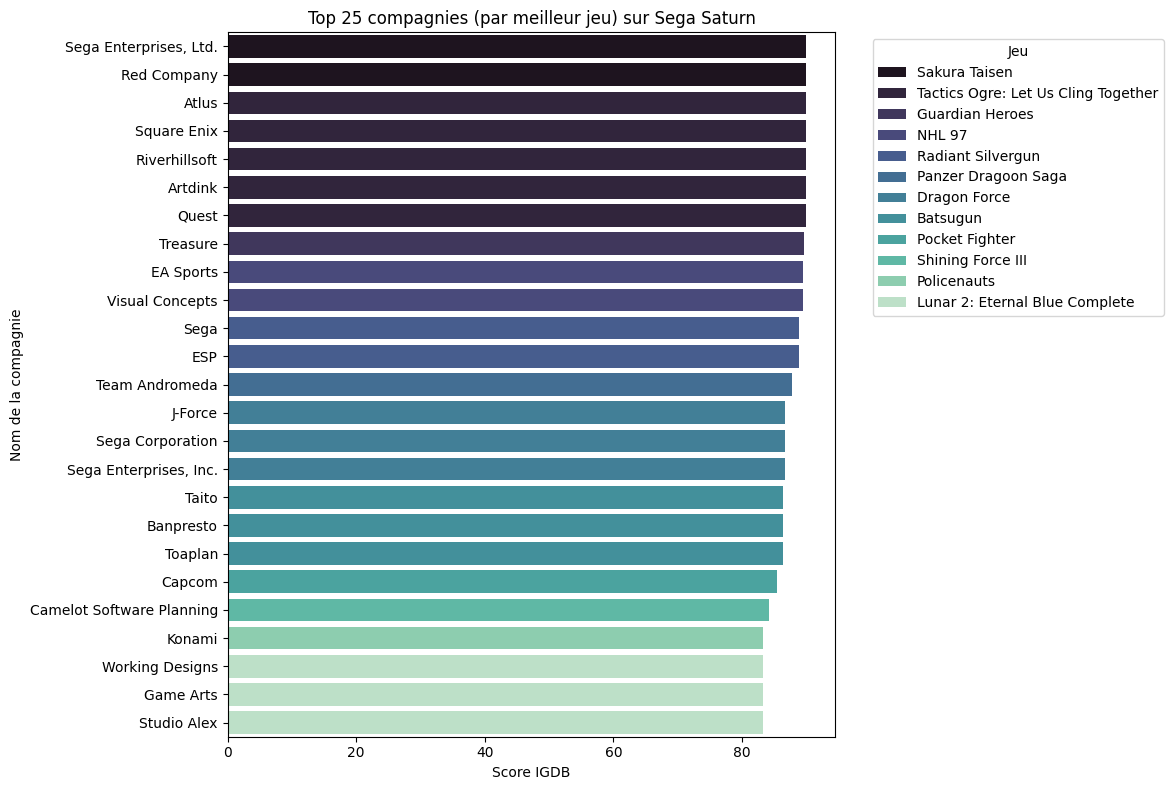

In [17]:
# Étape 1 : Récupérer les jeux triés par scoreIGDB décroissant
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT 
        CO.nomCompagnie AS Nom,
        J.titreJeu AS Jeu,
        J.scoreIGDB AS Score
    FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPLATEFORME = DS.IdPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIE CO ON CO.idCompagnie = CJ.idCompagnie
    WHERE P.nomPlateforme LIKE :libelle AND J.scoreIGDB IS NOT NULL
    ORDER BY J.scoreIGDB DESC
    """,
    {"libelle": NOM_PLATEFORME}
)

#Supprimer les doublons de compagnies pour ne garder que leur meilleur jeu
top_compagnies = data.drop_duplicates(subset="NOM", keep="first")

#Garder uniquement les 25 meilleures compagnies
top_25 = top_compagnies.head(25)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_25, x="SCORE", y="NOM", hue="JEU", dodge=False, palette="mako")
plt.title(f"Top 25 compagnies (par meilleur jeu) sur {NOM_PLATEFORME}")
plt.xlabel("Score IGDB")
plt.ylabel("Nom de la compagnie")
plt.legend(title="Jeu", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Graphiques : top 25 des compagnies ayant le plus développé, top 25 des compagnies ayant le plus publié, en nombre de jeux, sur cette plateforme

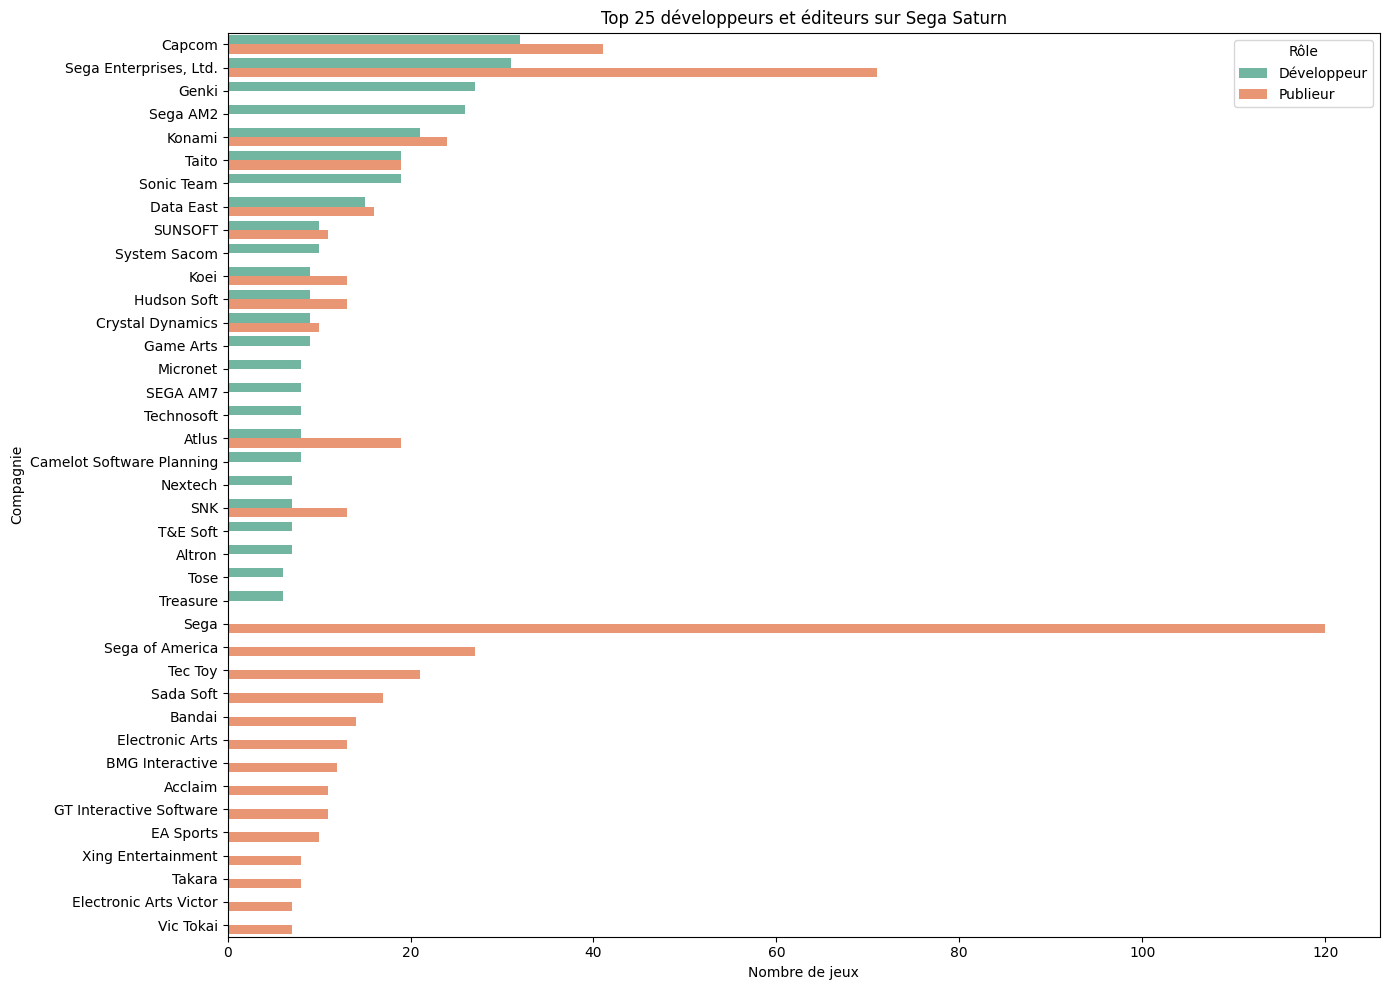

In [18]:
# Requêtes séparées
devs = requete_vers_dataframe(conn, f"""
    SELECT 
    CO.NomCompagnie AS NOM,
    COUNT(*) AS NBRJEU,
    'Développeur' AS ROLE
    FROM {SCHEMA}.COMPAGNIEJEU CJ
    INNER JOIN {SCHEMA}.COMPAGNIE CO ON CO.IdCompagnie = CJ.IdCompagnie
    INNER JOIN {SCHEMA}.JEU J ON J.IdJeu = CJ.IdJeu
    INNER JOIN {SCHEMA}.DATESORTIE DS ON DS.IdJeu = J.IdJeu
    INNER JOIN {SCHEMA}.PLATEFORME P ON P.IdPlateforme = DS.IdPlateforme
    WHERE CJ.EstDeveloppeur = 1 AND P.NomPlateforme LIKE :libelle
    GROUP BY CO.NomCompagnie
    ORDER BY NBRJEU DESC
    FETCH FIRST 25 ROWS ONLY
""", 
    {"libelle": NOM_PLATEFORME})

pubs = requete_vers_dataframe(conn,f"""
    SELECT 
    CO.NomCompagnie AS NOM,
    COUNT(*) AS NBRJEU,
    'Publieur' AS ROLE
    FROM {SCHEMA}.COMPAGNIEJEU CJ
    INNER JOIN {SCHEMA}.COMPAGNIE CO ON CO.IdCompagnie = CJ.IdCompagnie
    INNER JOIN {SCHEMA}.JEU J ON J.IdJeu = CJ.IdJeu
    INNER JOIN {SCHEMA}.DATESORTIE DS ON DS.IdJeu = J.IdJeu
    INNER JOIN {SCHEMA}.PLATEFORME P ON P.IdPlateforme = DS.IdPlateforme
    WHERE CJ.EstPublieur = 1 AND P.NomPlateforme LIKE :libelle
    GROUP BY CO.NomCompagnie
    ORDER BY NBRJEU DESC
    FETCH FIRST 25 ROWS ONLY
""", {"libelle": NOM_PLATEFORME})

# Fusionner les deux
data_top_50 = pd.concat([devs, pubs], ignore_index=True)

plt.figure(figsize=(14, 10))
sns.barplot(data=data_top_50, x="NBRJEU", y="NOM", hue="ROLE", palette="Set2")
plt.title(f"Top 25 développeurs et éditeurs sur {NOM_PLATEFORME}")
plt.xlabel("Nombre de jeux")
plt.ylabel("Compagnie")
plt.legend(title="Rôle", loc="upper right")
plt.tight_layout()
plt.show()

## Partie modification des données

In [19]:
# Avant de commencer, on affiche le nombre de jeux sortis sur la plateforme et le top 10 des jeux les mieux notés par les utilisateurs, critiques et combinés sur la plateforme

#nbr de jeux
nbrDeJeux()

top_user = requete_vers_dataframe(
    conn,
    f"""
    SELECT DISTINCT
        J.titreJeu AS Jeu,
        J.scoreIGDB AS Score
        FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPLATEFORME = DS.IdPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = DS.idJeu
    WHERE P.nomPlateforme LIKE :libelle AND J.scoreIGDB IS NOT NULL
    ORDER BY J.scoreIGDB DESC
    FETCH FIRST 10 ROW ONLY
    """,
    {"libelle": NOM_PLATEFORME}
)
print("")
print("Top 10 des jeux les mieux notés par les utilisateurs : ")
for top10U in top_user["JEU"]:
    print("-", top10U)

top_crit = requete_vers_dataframe(
    conn,
    f"""
    SELECT DISTINCT
        J.titreJeu AS Jeu,
        J.scoreIGDB AS Score
        FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPLATEFORME = DS.IdPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = DS.idJeu
    WHERE P.nomPlateforme LIKE :libelle AND J.ScoreAgregeJeu IS NOT NULL
    ORDER BY J.ScoreAgregeJeu DESC
    FETCH FIRST 10 ROW ONLY
    """,
    {"libelle": NOM_PLATEFORME}
)
print("")
print("Top 10 des jeux les mieux notés par les crtiques : ")
for top10C in top_crit["JEU"]:
    print("-", top10C)

top_C_U = requete_vers_dataframe(
    conn,
    f"""
    SELECT DISTINCT
        J.titreJeu AS Jeu,
        J.scoreIGDB AS Score
        FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPLATEFORME = DS.IdPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = DS.idJeu
    WHERE P.nomPlateforme LIKE :libelle AND J.ScoreJeu IS NOT NULL
    ORDER BY ScoreJeu DESC
    FETCH FIRST 10 ROW ONLY
    """,
    {"libelle": NOM_PLATEFORME}
)
print("")
print("Top 10 des jeux les mieux notés par les crtiques et les utilisateurs : ")
for top10CU in top_C_U["JEU"]:
    print("-", top10CU)

Nombres de jeux :  787

Top 10 des jeux les mieux notés par les utilisateurs : 
- Sakura Taisen
- Tactics Ogre: Let Us Cling Together
- Guardian Heroes
- NHL 97
- Radiant Silvergun
- Panzer Dragoon Saga
- Dragon Force
- Batsugun
- Pocket Fighter
- Shining Force III

Top 10 des jeux les mieux notés par les crtiques : 
- Tactics Ogre: Let Us Cling Together
- Super Puzzle Fighter II Turbo
- Guardian Heroes
- Radiant Silvergun
- Bottom of the 9th
- NBA Live 97
- MechWarrior 2: Arcade Combat Edition
- Rayman
- Shin Megami Tensei: Devil Summoner
- Loaded

Top 10 des jeux les mieux notés par les crtiques et les utilisateurs : 
- Tactics Ogre: Let Us Cling Together
- Sakura Taisen
- NHL 97
- Panzer Dragoon Saga
- Guardian Heroes
- Radiant Silvergun
- Dragon Force
- Batsugun
- Pocket Fighter
- Shining Force III


### Ajout d'une nouvelle compagnie

Ajoutez à la base une nouvelle compagnie ayant pour nom *Binôme XXX* où XXX est votre numéro de binôme.

In [105]:
# Ajouter la compagnie ici
#Binome 21

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.COMPAGNIE(idCompagnie, nomCompagnie, descrCompagnie, paysCompagnie, datefondationCompagnie, dateMajCompagnie)
    VALUES (:idCompagnie, :nomCompagnie, :descrCompagnie, :paysCompagnie, SYSDATE, SYSDATE)
    """
    params = {
    "idCompagnie" : 100000,
    "nomCompagnie" : "Binôme 21",
    "descrCompagnie" : "La meilleure compagnie de 2025",
    "paysCompagnie" : 250
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print(" ✅ Compagnie ajoutée")

 ✅ Compagnie ajoutée


### Ajout d'un nouveau jeu

Ajouter le nouveau jeu "BDWarrior 2025" développé et publié par la compagnie crée précédemment. Pour le moment, les scores et nombre de notes sont vides, et vous pouvez choisir les autres propriétés à votre goût.

In [106]:
# Ajouter le jeu ici
with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.JEU(
    idJeu,
    titreJeu,
    titreVersionJeu,
    histoireJeu,
    resumeJeu,
    statutJeu,
    dateMajJeu,
    franchisePrincipaleJeu,
    categorieJeu,
    urlJeu
    )
    VALUES (:idJeu, :titre, :titreVersion, :histoire, :resume, :statut, SYSDATE, :franchise, :categorie, :url)
    """
    params = {
    "idJeu" : 100000,
    "titre" : "BDWarrior 2025",
    "titreVersion" :  "BDWaluigi 2025",
    "histoire" : "Ce jeu a été créer en 2025 par alex hitchens",
    "resume" : "Il faut tuer les petits squelettes et monter en puissance jusqu'au boss final",
    "statut" : "Beta",
    "franchise" : 12,
    "categorie" : 0,
    "url" : "https://bdwarrior-2025"
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Jeu ajouté")

# Faire ensuite les liens avec les tables COMPAGNIE, THEME, CATEGORIEJEU, REGION, MOTCLE...

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.CompagnieJeu(
        idJeu,
        idCompagnie,
        estDeveloppeur,
        estPorteur,
        estPublieur,
        estSoutien
    )
    VALUES (:idJeu, :compagnie, :developpeur, :porteur, :publieur, :soutien)
    """
    params = {
    "idJeu" : 100000,
    "compagnie" : 100000,
    "developpeur" : 1,
    "porteur" : 0,
    "publieur" : 1,
    "soutien" : 0
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Lien avec compagnie effectué")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.THEMEJEU(
        idTheme,
        idJeu
    )
    VALUES (:idtheme, :idJeu)
    """
    params = {
    "idTheme" : 1,
    "idJeu" : 100000
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Lien avec ThèmeJeu effectué")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.LOCALISATIONJEU(
        idJeu,
        idRegion
    )
    VALUES (:idJeu, :idRegion)
    """
    params = {
    "idJeu" : 100000,
    "idRegion" : 4
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Lien avec LocalisationJeu effectué")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.MOTEURJEU(
        idJeu,
        idMoteur
    )
    VALUES (:idJeu, :idMoteur)
    """
    params = {
    "idJeu" : 100000,
    "idMoteur" : 1729
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Lien avec MoteurJeu effectué")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.CLASSIFICATIONJEU(
        idClassification,
        idJeu
    )
    VALUES (:idClassification, :idJeu)
    """
    params = {
    "idClassification" : 68457,
    "idJeu" : 100000
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Lien avec Classification effectué")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.GENREJEU(
        idJeu,
        idGenre
    )
    VALUES (:idJeu, :idGenre)
    """
    params = {
    "idJeu" : 100000,
    "idGenre" : 15
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Lien avec GenreJeu effectué")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.MOTCLEJEU(
        idMotCle,
        idJeu
    )
    VALUES (:idMotCle, :idJeu)
    """
    params = {
    "idMotCle" : 3623,
    "idJeu" : 100000
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Lien avec MotCle effectué")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    sql = f"""
    INSERT INTO {SCHEMA}.MODALITEJEU(
        idModalite,
        idJeu
    )
    VALUES (:idModalite, :idJeu)
    """
    params = {
    "idModalite" : 2,
    "idJeu" : 100000
        
    }
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Lien avec ModaliteJeu effectué")

✅ Jeu ajouté
✅ Lien avec compagnie effectué
✅ Lien avec ThèmeJeu effectué
✅ Lien avec LocalisationJeu effectué
✅ Lien avec MoteurJeu effectué
✅ Lien avec Classification effectué
✅ Lien avec GenreJeu effectué
✅ Lien avec MotCle effectué
✅ Lien avec ModaliteJeu effectué


### Ajout d'une nouvelle date de sortie

Le jeu est sorti mondialement le 28/05/2025 sur la plateforme qui vous a été assignée.

In [107]:
# Ajouter la sortie ici
with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    date_sortie = '2025-05-28'
    date_maj_date_sortie = '2025-05-28'

    sql = f"""
    INSERT INTO {SCHEMA}.DATESORTIE(
        idDateSortie,
        idJeu,
        idPlateforme,
        dateSortie,
        regionSortie,
        dateMajDateSortie
    )
    VALUES (:idDateSortie, :idJeu, :idPlateforme, TO_DATE(:dateSortie, 'YYYY-MM-DD'), :regionSortie, TO_DATE(:dateMajDateSortie, 'YYYY-MM-DD'))
    """
    params = {
        "idDateSortie" : 30,
        "idJeu" : 100000,
        "idPlateforme" : 32,
        "dateSortie" : date_sortie,
        "regionSortie" : 'worldwide',
        "dateMajDateSortie" : date_maj_date_sortie
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()

print("✅ Ajout date sortie effectué")

✅ Ajout date sortie effectué


### Affichage

In [32]:
# On affiche la fiche détaillée des sorties du jeu (avec DETAIL_SORTIES)
oracledb.defaults.fetch_lobs = False

data = requete_vers_dataframe(
    conn,
    f"""
    SELECT {SCHEMA}.DETAILS_SORTIES(100000) AS resultat FROM DUAL
    """
)
data.iloc[0:1]

,RESULTAT
0,"{""id"":100000,""titre"":""BDWarrior 2025"",""sorties..."


### Première vérification

On vérifie maintenant que le nombre de jeux sur la plateforme reflète l'ajout que l'on vient de faire.

In [33]:
# On affiche le nombre de jeux sortis sur la plateforme
nbrDeJeux()

Nombres de jeux :  788


### Evaluation du jeu

Votre jeu est un immense succès, il obtient une note parfaite tant chez les utilisateurs que chez les critiques. Mettez à jour la base pour refléter cela.

In [108]:
# Faire la mise à jour des notes
with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    
    sql = f"""
    UPDATE {SCHEMA}.JEU
    SET 
        scoreIGDB = :scoreIGDB,
        scoreAgregeJeu = :scoreAgregeJeu,
        scoreJeu = :scoreJeu
    WHERE idJeu = 100000
    """
    params = {
        "scoreIGDB" : 100,
        "scoreAgregeJeu" : 100,
        "scoreJeu" : 100
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()

print("✅ Modification scores du jeu effectué")

✅ Modification scores du jeu effectué


### Seconde vérification

On regarde maintenant le top 10 des jeux les mieux notés sur les trois critères sur la plateforme

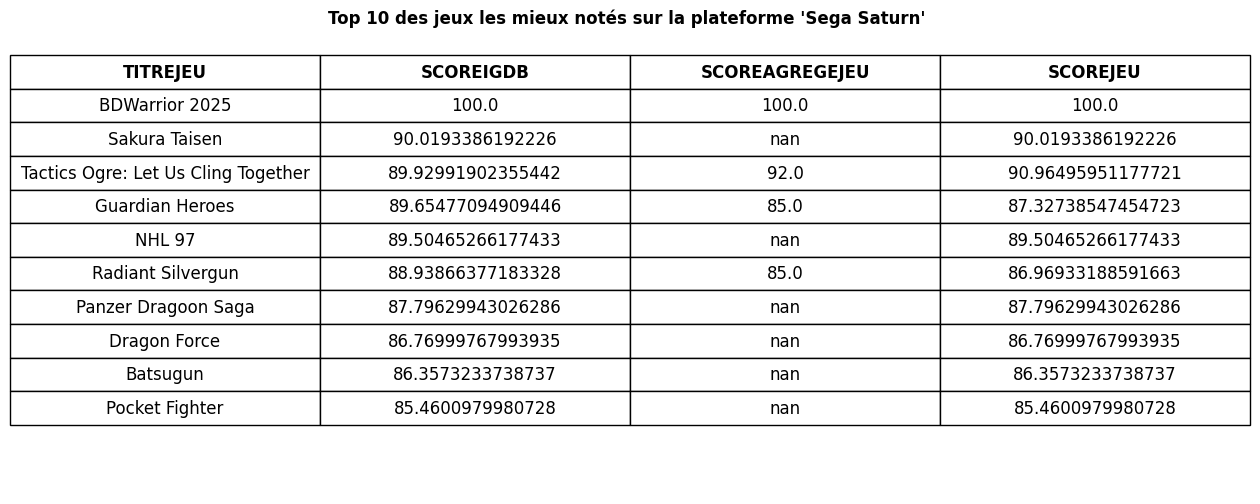

In [35]:
# Afficher les nouveaux top 10 ici
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT DISTINCT J.titreJeu, J.scoreIGDB, J.scoreAgregeJeu, J.scoreJeu
    FROM iluis.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPlateforme = DS.idPlateforme
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = DS.idJeu
    WHERE P.nomPlateforme LIKE :libelle AND J.scoreIGDB IS NOT NULL
    ORDER BY J.scoreIGDB DESC
    """,
    {"libelle": NOM_PLATEFORME}
)
'''for i in range(10):
    print("-", str(data.iloc[i, 0]), " : ", data.iloc[i, 1])
'''
fig, ax = plt.subplots(figsize=(16, 6))  # Taille du graphique
data_top_10 = data.head(10)
ax.axis('off')

table1 = ax.table(cellText=data_top_10.values, colLabels=data_top_10.columns, loc='center', cellLoc='center', colLoc='center', bbox=[0, 0.15, 1, 0.8])

table1.auto_set_font_size(False)
table1.set_fontsize(12)

# première ligne en gras
for (row, col), cell in table1.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

plt.title(f"Top 10 des jeux les mieux notés sur la plateforme '{NOM_PLATEFORME}' ", fontweight='bold')
plt.show()

### Nettoyage

Annulez maintenant vos modifications

In [109]:
# Nettoyage de la base ici (avec des requêtes DELETE)

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.COMPAGNIE
    WHERE idCompagnie = :idCompagnie
    """

    params = {
        "idCompagnie": 100000  # Id de la compagnie à supprimer
    }
    
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Compagnie supprimée avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.JEU
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }
    
    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Jeu supprimée avec succès.")
    
with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.COMPAGNIEJEU
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ CompagnieJeu supprimé avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.THEMEJEU
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Thème supprimé avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.LOCALISATIONJEU
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ LocalisationJeu supprimé avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.MOTEURJEU
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ MoteurJeu supprimé avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.CLASSIFICATIONJEU
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Jeu supprimé avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.GENREJEU
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Genre supprimé avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.MOTCLEJEU
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ Jeu supprimé avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.ModaliteJeu
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ ModaliteJeu supprimé avec succès.")

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()

    sql = f"""
    DELETE FROM {SCHEMA}.DATESORTIE
    WHERE idJeu = :idJeu
    """

    params = {
        "idJeu": 100000  # Id de la compagnie à supprimer
    }

    curseur.execute(sql, params)
    connexion.commit()
    curseur.close()
print("✅ DateSortie supprimé avec succès.")

✅ Compagnie supprimée avec succès.
✅ Jeu supprimée avec succès.
✅ CompagnieJeu supprimé avec succès.
✅ Thème supprimé avec succès.
✅ LocalisationJeu supprimé avec succès.
✅ MoteurJeu supprimé avec succès.
✅ Jeu supprimé avec succès.
✅ Genre supprimé avec succès.
✅ Jeu supprimé avec succès.
✅ ModaliteJeu supprimé avec succès.
✅ DateSortie supprimé avec succès.
